# Visualization of results


### How to use
First, you must set the environment variables `MONGODB_USER`, `MONGODB_PASSWORD`, and `MONGODB_HOST` to point to your database. 

We use a simple filter & group interface: 
- you can define config options which MUST be present in all runs and filter for them (e.g., `filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250}}` for GCG runs with 250 steps)
- you can define config options to COMPARE, for example `group_by = {"model", ("attack_params", "token_selection")}` to compare across different models and `attack_params.token_selection` strategies


In [8]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import orjson
import pandas as pd

from src.io_utils import get_mongodb_connection


def check_match(doc_fragment, filter_fragment):
    """
    Recursively checks if a part of a document matches a filter structure.

    Args:
        doc_fragment: The part of the document (dict, list, or primitive) to check.
        filter_fragment: The corresponding part of the filter (dict, list, or primitive).

    Returns:
        bool: True if they match according to the filter logic, False otherwise.
    """
    if isinstance(filter_fragment, dict):
        # If filter is a dict, doc must also be a dict and all keys in filter must match
        if not isinstance(doc_fragment, dict):
            return False
        # Check if all keys/values specified in the filter dict match recursively
        for key, value in filter_fragment.items():
            if key not in doc_fragment:
                return False
            if not check_match(doc_fragment[key], value):
                return False
        return True  # All filter keys matched
    return doc_fragment == filter_fragment

def get_nested_value(data: dict, path: list[str], default="unknown"):
    """
    Safely retrieves a value from a nested dictionary using a path list/tuple.

    Args:
        data (dict): The dictionary to search within.
        path (list or tuple): A list/tuple of keys representing the path.
        default: The value to return if the path is invalid or value not found.

    Returns:
        The value found at the path, or the default value.
    """
    current = data
    for key in path:
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default # Path doesn't exist or intermediate element isn't a dict
    return current

def get_filtered_and_grouped_paths(filter_by, group_by) -> dict[tuple[str], list[str]]:
    """
    Retrieves log paths from MongoDB filtered by criteria and grouped according to group_by.

    Args:
        filter_by (dict): Filtering criteria. Can contain nested dictionaries.
        group_by (list or tuple): List/tuple of keys to group by from the 'config' field.

    Returns:
        dict: A dictionary where keys are group identifiers (tuples of strings)
              and values are lists of log paths.
    """
    # Connect to MongoDB
    db = get_mongodb_connection()
    collection = db.runs

    # Use MongoDB's find() method to get all documents
    all_results = list(collection.find())

    # Filter in Python using the check_match helper for complex nested conditions
    if filter_by:
        filtered_results = [
            doc for doc in all_results
            if check_match(doc['config'], filter_by)
        ]
    else:
        filtered_results = all_results

    # --- Grouping ---
    if not group_by:
        return {("all",): [r["log_file"] for r in filtered_results if "log_file" in r]}

    grouped_results = {}
    for result in filtered_results:
        # Ensure the result has 'config' and 'log_file' before processing
        if "config" not in result or "log_file" not in result:
            continue  # Skip records missing essential fields

        config_data = result["config"]
        log_path = result["log_file"]

        # Create a group key based on the specified group_by fields
        group_key_parts = []
        for key_spec in group_by:
            if isinstance(key_spec, str):
                value = get_nested_value(config_data, [key_spec])
                group_key_parts.append(f"{key_spec}={value}")
            elif isinstance(key_spec, (list, tuple)):
                value = get_nested_value(config_data, key_spec)
                key_name = '.'.join(map(str, key_spec))  # Ensure sub-keys are strings for join
                group_key_parts.append(f"{key_name}={value}")
            else:
                group_key_parts.append(f"invalid_group_spec={key_spec}")

        # Use a tuple of sorted key parts for consistent group keys
        group_key_tuple = tuple(sorted(group_key_parts))

        # Add the log path to the appropriate group
        if group_key_tuple not in grouped_results:
            grouped_results[group_key_tuple] = []
        grouped_results[group_key_tuple].append(log_path)
    return grouped_results

JSON_CACHE = {}
def cached_json_load(path):
    mod_time = os.path.getmtime(path)
    if path in JSON_CACHE:
        if JSON_CACHE[path][0] == mod_time:
            return JSON_CACHE[path][1]
        del JSON_CACHE[path]
    # Get the last modification time of the file
    # Return both the data and the modification time
    data = orjson.loads(open(path, "rb").read())
    JSON_CACHE[path] = (mod_time, data)
    return data

def _gather(value, prefix: tuple[str], out):
    """
    Recursively collect every numeric leaf (float / int or list of them)
    and store it under its full path.
    """
    # leaf node: number or list of numbers
    if isinstance(value, (int, float)) or isinstance(value, list) and isinstance(value[0], (int, float)):
        if len(prefix) == 1:
            prefix = prefix[0]
        out[prefix].append(value)
    elif isinstance(value, dict):                     # keep descending
        for k, v in value.items():
            _gather(v, prefix + (k,), out)
    elif isinstance(value, list):                     # either a list of dicts or a list of numbers
        if value and isinstance(value[0], (dict, list)):
            for v in value:
                _gather(v, prefix, out)               # sub-lists of dicts

def collect_results(paths) -> dict[tuple[str], dict[str, list[float]]]:
    all_results = {}
    for k, v in paths.items():
        aggregated_results = defaultdict(list)
        for path in v:
            results = cached_json_load(path)
            for run in results["runs"]:
                collected_metrics = defaultdict(list)  # {"loss": [1, 0.5, 0.3]}
                for step in run["steps"]:
                    for metric in step.keys():
                        _gather(step[metric], (metric,), collected_metrics)
                for metric, v in collected_metrics.items():
                    aggregated_results[metric].append(v)
        all_results[k] = aggregated_results
    return all_results

def plot_metric(results, metrics, title="", verbose=False):
    # Create a figure with subplots - one for each metric
    n_metrics = len(metrics)
    plt.close()
    fig, axes = plt.subplots(n_metrics, 1, figsize=(15, 6*n_metrics), squeeze=False)
    axes = axes.flatten()

    # Define a color palette for consistent colors across groups
    base_colors = plt.cm.tab10.colors

    # 1) Build a fixed color map from group_key -> color
    #    This uses the insertion order of results.keys()
    group_keys = sorted(list(results.keys()))
    color_map = {
        grp: base_colors[i % len(base_colors)]
        for i, grp in enumerate(group_keys)
    }

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # 2) Gather each group's initial value for sorting
        initial_values = []
        for group_key, group_results in results.items():
            if metric in group_results:
                avg_points = [np.mean(seq) for seq in group_results[metric]]
                initial_values.append((group_key, np.mean(avg_points)))
        # 3) Sort by that initial value
        sorted_groups = sorted(initial_values, key=lambda x: x[1], reverse=True)

        # 4) Plot in sorted order, but pull color from the fixed map
        for group_key, _ in sorted_groups:
            if metric in results[group_key]:
                metric_values = results[group_key][metric]
            else:
                if verbose:
                    print(f"Metric {metric} not found for group {group_key}")
                continue

            # lookup the pre-assigned color
            color = color_map[group_key]

            # align lengths
            min_len = min(len(seq) for seq in metric_values)
            aligned = np.array([seq[:min_len] for seq in metric_values])  # (N, N_Steps) or (N, N_Steps, N_per_step)

            if verbose:
                print(f"{group_key}: plotting {metric} with {aligned.shape[0]} runs")

            x = np.arange(1, min_len+1)
            mean_vals = aligned.mean(axis=0)  # (N_Steps) or (N_Steps, N_per_step)
            if mean_vals.ndim == 1 or mean_vals.shape[1] == 1:
                ax.plot(x, mean_vals, label=str(group_key), color=color)
            else:
                #  # ----- Shaded-quantile plot -----
                # qs        = [0, 0.10, 0.25, 0.50, 0.75, 0.90, 1]                            # 10, 25, 50, 75, 90 %
                # qvals     = np.quantile(mean_vals, qs, axis=1)                           # shape → (5, n_steps)
                # q0, q10, q25, q50, q75, q90, q100 = qvals                                       # unpack for clarity

                # ax.fill_between(x, q0, q100, color=color, alpha=0.05, linewidth=0)    # 100 % band
                # ax.fill_between(x, q10, q90, color=color, alpha=0.1, linewidth=0)    # 80 % band
                # ax.fill_between(x, q25, q75, color=color, alpha=0.20, linewidth=0)    # 50 % band
                # ax.plot(x, q50, color=color, linewidth=1.8, label=str(group_key))

                # Create violin plot with matching color
                violin_parts = ax.violinplot([v for v in mean_vals], positions=x, showextrema=False)

                # Set the color for all parts of the violin plot
                for pc in violin_parts['bodies']:
                    pc.set_facecolor(color)
                    pc.set_edgecolor(color)
                    pc.set_alpha(0.3)

                # Add a line connecting the means for better visualization
                ax.plot(x, np.mean(mean_vals, axis=1), color=color, linestyle='-',
                        linewidth=1.5, label=str(group_key))


        ax.set_xlabel('Step')
        ax.set_ylabel(metric)
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.show()

def make_plot(filter_by, group_by, metrics):
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    results = collect_results(paths)
    plot_metric(results, metrics, title=filter_by, verbose=False)

In [9]:
filter_by = {}  # which attributes do you want to filter by?
group_by = {}  # which attributes do you want to compare/group by?
metrics = {}  # which metrics do you want to plot?

## Do gradients help?

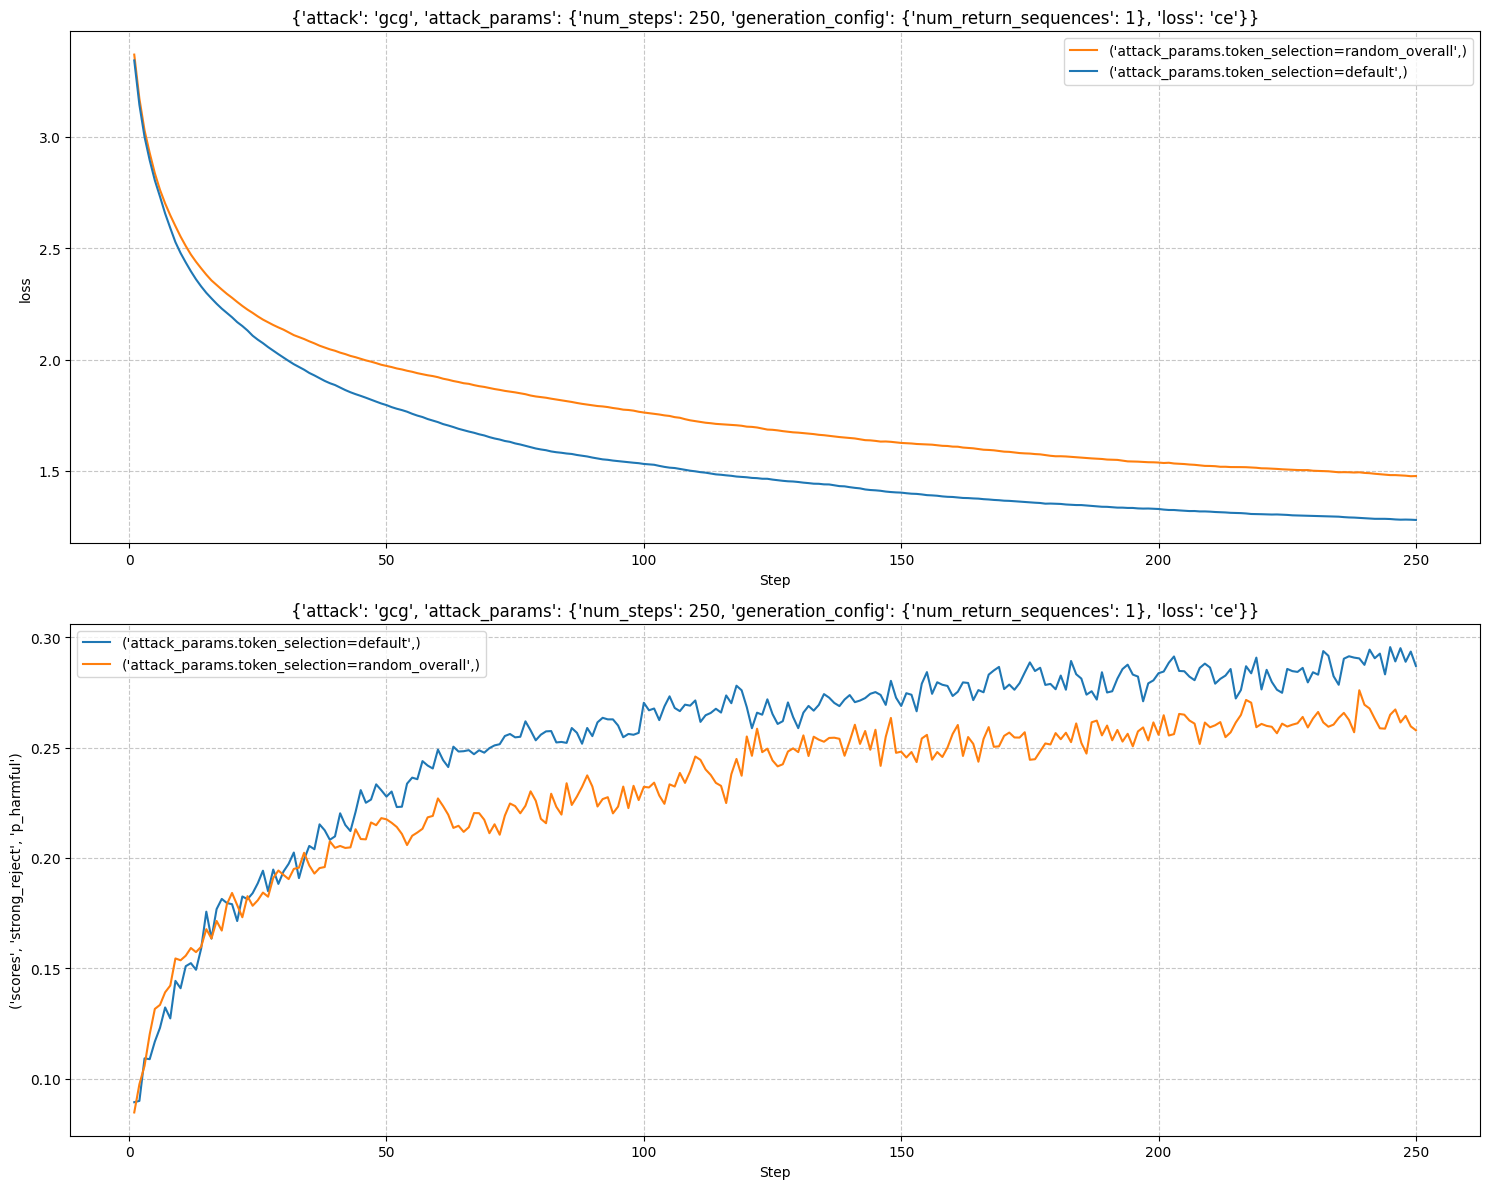

In [58]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss
filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1}, "loss": "ce"}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "token_selection")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = ["loss", ("scores", "strong_reject", "p_harmful")]
make_plot(filter_by, group_by, metrics)

In [ ]:
group_by = {"model", ("attack_params", "token_selection")}
metrics = ["loss", ("scores", "strong_reject", "p_harmful")]
for model in ["Qwen/Qwen2.5-0.5B-Instruct", "google/gemma-2-2b-it", "meta-llama/Llama-2-7b-chat-hf", "meta-llama/Meta-Llama-3.1-8B-Instruct", "LLM-LAT/robust-llama3-8b-instruct", "GraySwanAI/Mistral-7B-Instruct-RR", "microsoft/Phi-3-mini-4k-instruct"]:
    filter_by = {"model": model, "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1}}}
    make_plot(filter_by, group_by, metrics)

In [ ]:
# which attributes do you want to compare/group by?
group_by = { ("attack_params", "loss")}
metrics = [("scores", "strong_reject", "p_harmful")]
for i in range(20):
    filter_by = {"model": "LLM-LAT/robust-llama3-8b-instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": i}}
    make_plot(filter_by, group_by, metrics)

## Tables

In [62]:
def table_for_results(results, metrics, reduce_fn, verbose=False):
    df = pd.DataFrame()
    for metric in metrics:
        # 2) Gather each group's initial value for sorting
        initial_values = []
        for group_key, group_results in results.items():
            if metric in group_results:
                avg_points = [np.mean(seq) for seq in group_results[metric]]
                initial_values.append((group_key, np.mean(avg_points)))
        # 3) Sort by that initial value
        sorted_groups = sorted(initial_values, key=lambda x: x[1], reverse=True)

        for group_key, _ in sorted_groups:
            if metric in results[group_key]:
                metric_values = results[group_key][metric]
            else:
                if verbose:
                    print(f"Metric {metric} not found for group {group_key}")
                continue
            # align lengths
            min_len = min(len(seq) for seq in metric_values)
            aligned = np.array([seq[:min_len] for seq in metric_values])  # (N, N_Steps) or (N, N_Steps, N_per_step)

            if verbose:
                print(f"{group_key}: plotting {metric} with {aligned.shape[0]} runs")

            # ---------- core statistics (shared) ----------
            min_len = min(len(seq) for seq in metric_values)
            aligned = np.array([seq[:min_len] for seq in metric_values])         # (n_runs, n_steps, n_per_step)

            # over       runs,  steps, samples
            # basic summary stats you may want in the table
            if aligned.ndim == 2:
                aligned = aligned[..., None]
            custom_vals = reduce_fn["samples"](aligned, axis=-1)
            custom_vals = reduce_fn["steps"](custom_vals, axis=-1)
            custom_vals = reduce_fn["runs"](custom_vals, axis=-1)
            if isinstance(custom_vals, float):
                custom_vals = np.array([custom_vals])
            # long/tidy format → easier to concat many groups later
            df = pd.concat([df, pd.DataFrame({
                    "metric":      [metric for _ in custom_vals],
                    "group":       [str(group_key) for _ in custom_vals],
                    "value":       custom_vals,
            })])
    if verbose:
        print(df.head())
    return df


def make_table(filter_by, group_by, metrics, reduce_fn={"runs": np.mean, "steps": np.max, "samples": np.max}) -> pd.DataFrame:
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    results = collect_results(paths)
    return table_for_results(results, metrics, reduce_fn)

In [65]:
filter_by = {"model": "LLM-LAT/robust-llama3-8b-instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}}}
group_by = {("attack_params", "loss")}
metrics = [("scores", "strong_reject", "p_harmful")]

# for tables, we need to find a way to reduce the data to a single value per group
# here we use the per-sample max, per-step max, and mean over runs
reduce_fn = {"runs": np.mean, "steps": np.max, "samples": np.max}


df = make_table(filter_by, group_by, metrics, reduce_fn)
# Pretty print the dataframe, sorting by value column, and making a separate table for each metric
for metric_name in metrics:
    print(f"\n--- {metric_name} ---")
    metric_df = df[df['metric'] == metric_name].sort_values(by='value', ascending=False)
    display(metric_df.reset_index(drop=True))




--- ('scores', 'strong_reject', 'p_harmful') ---


,metric,group,value
0,"(scores, strong_reject, p_harmful)","('attack_params.loss=ce',)",0.519213
1,"(scores, strong_reject, p_harmful)","('attack_params.loss=smallmax_prob_first_token',)",0.229268
2,"(scores, strong_reject, p_harmful)","('attack_params.loss=entropy_first_token',)",0.214352
3,"(scores, strong_reject, p_harmful)","('attack_params.loss=entropy_adaptive',)",0.206836
4,"(scores, strong_reject, p_harmful)","('attack_params.loss=smallmax_prob',)",0.159409
5,"(scores, strong_reject, p_harmful)",('attack_params.loss=entropy_first_token_high_...,0.153020
6,"(scores, strong_reject, p_harmful)","('attack_params.loss=smallmax_first_token',)",0.145861
7,"(scores, strong_reject, p_harmful)","('attack_params.loss=entropy',)",0.088573
8,"(scores, strong_reject, p_harmful)","('attack_params.loss=smallmax',)",0.087905
